# Ensemble : Bagging

## 1.환경준비

### (1) import

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 모델링
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')

### (2) 데이터 준비

* 변수설명
    * COLLEGE : 대학 졸업여부
    * INCOME : 연수입
    * OVERAGE : 월평균 초과사용 시간(분)
    * LEFTOVER : 월평균 잔여시간비율(%)
    * HOUSE : 집값
    * HANDSET_PRICE : 스마트폰 가격
    * OVER_15MINS_CALLS_PER_MONTH : 월평균 장기통화(15분이상) 횟수
    * AVERAGE_CALL_DURATION : 평균 통화 시간
    * REPORTED_SATISFACTION : 만족도 설문조사 결과
    * REPORTED_USAGE_LEVEL : 사용도 자가진단 결과
    * CONSIDERING_CHANGE_OF_PLAN : 향후 변경계획 설문조사 결과
    * CHURN : 이탈(번호이동) 여부 (1-이탈, 0-잔류, Target 변수)


In [2]:
# 데이터를 불러옵시다.
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv'
data = pd.read_csv(path)
data = data.sample(5000, random_state = 2022)
data['CHURN'] = data['CHURN'].map({'LEAVE':1, 'STAY':0}) # 점진선택법에서 필요한 코드, 그냥 넣어두었음
data.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
3178,3179,0,119512,51,31,248566,229,5,2,very_sat,very_high,considering,1
14926,14927,1,142144,192,15,774317,581,29,4,unsat,very_little,never_thought,1
15116,15117,1,142308,0,79,306426,497,1,1,sat,little,considering,0
12733,12734,1,113385,0,0,333599,819,1,6,very_unsat,very_high,considering,1
14032,14033,1,90348,209,10,637286,360,26,4,unsat,little,actively_looking_into_it,0


## 2.데이터 준비

### (1) 데이터 정리

In [3]:
drop_cols = ['id']
data.drop(drop_cols, axis = 1, inplace = True )

### (2) 데이터분할1 : x, y 나누기

In [4]:
target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (3) NA 조치

### (4) 가변수화

In [5]:
dumm_cols = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
x = pd.get_dummies(x, columns = dumm_cols, drop_first = True)

### (5) 데이터분할2 : train : validation

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state = 2022)

## 3.모델링 : 랜덤포레스트


In [7]:
# 모델 선언
model = RandomForestClassifier(n_estimators = 5, max_depth = 3)

In [8]:
# 학습
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=5)

In [9]:
# 예측
pred = model.predict(x_val)

In [10]:
# 평가
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.67      0.76      0.71       769
           1       0.71      0.60      0.65       731

    accuracy                           0.68      1500
   macro avg       0.69      0.68      0.68      1500
weighted avg       0.69      0.68      0.68      1500



## 4.시각화와 변수중요도

### (1) 모델의 내부를 살펴봅시다.

In [11]:
# 5개 decision tree
model.estimators_ # 모델

[DecisionTreeClassifier(max_depth=3, max_features='auto',
                        random_state=1970640323),
 DecisionTreeClassifier(max_depth=3, max_features='auto', random_state=42180149),
 DecisionTreeClassifier(max_depth=3, max_features='auto', random_state=123324378),
 DecisionTreeClassifier(max_depth=3, max_features='auto', random_state=276489622),
 DecisionTreeClassifier(max_depth=3, max_features='auto', random_state=839414020)]

In [12]:
model.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='auto',
                       random_state=1970640323)

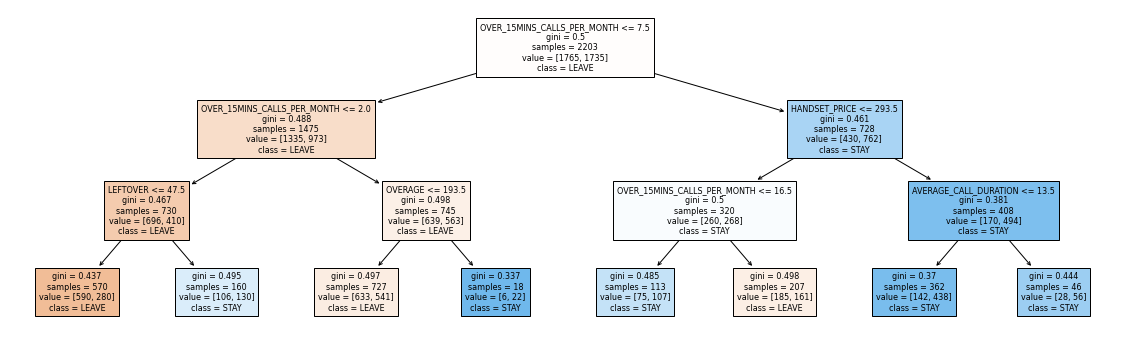

In [13]:
# 각 트리별로 시각화 할 수 있다. -> 앙살블도 시각화를 볼 수 있지만, 꼭 의미가 있는 것은 아님,(별도 설치 필요 오류가 많이 남!) 
plt.figure(figsize=(20,6))
plot_tree(model.estimators_[0], # 각 모델을 살펴볼 수 있음
               feature_names = x_train.columns,
               class_names= ['LEAVE','STAY'], 
               filled = True, fontsize = 8);

### (2) 변수 중요도

In [14]:
# 변수 중요도
print(x_train.columns)
print(model.feature_importances_)

Index(['COLLEGE', 'INCOME', 'OVERAGE', 'LEFTOVER', 'HOUSE', 'HANDSET_PRICE',
       'OVER_15MINS_CALLS_PER_MONTH', 'AVERAGE_CALL_DURATION',
       'REPORTED_SATISFACTION_sat', 'REPORTED_SATISFACTION_unsat',
       'REPORTED_SATISFACTION_very_sat', 'REPORTED_SATISFACTION_very_unsat',
       'REPORTED_USAGE_LEVEL_high', 'REPORTED_USAGE_LEVEL_little',
       'REPORTED_USAGE_LEVEL_very_high', 'REPORTED_USAGE_LEVEL_very_little',
       'CONSIDERING_CHANGE_OF_PLAN_considering',
       'CONSIDERING_CHANGE_OF_PLAN_never_thought',
       'CONSIDERING_CHANGE_OF_PLAN_no', 'CONSIDERING_CHANGE_OF_PLAN_perhaps'],
      dtype='object')
[0.         0.05647499 0.1321799  0.0487922  0.28531388 0.09671661
 0.31930004 0.04451136 0.         0.         0.         0.
 0.         0.         0.         0.00088603 0.01582499 0.
 0.         0.        ]


* 변수중요도 그래프 그리기 함수 만들기

In [14]:
def plot_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df.reset_index(drop=True, inplace = True)

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.grid()

    return fi_df

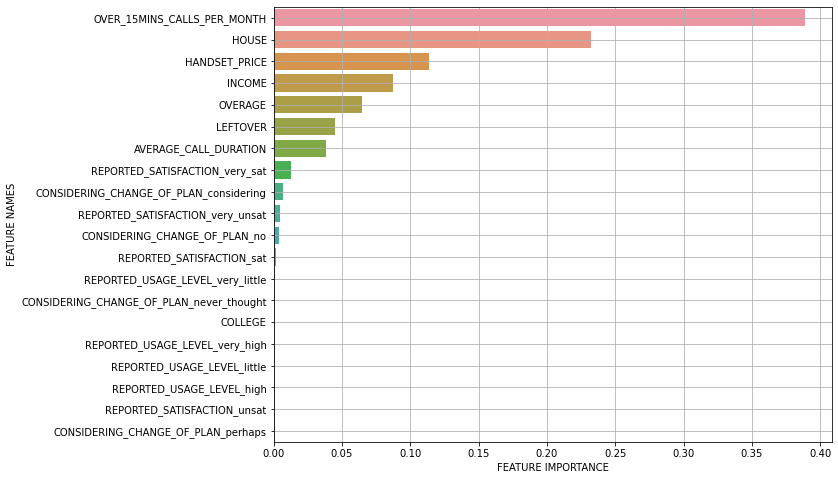

In [15]:
result = plot_feature_importance(model.feature_importances_, x_train.columns)

## 5.실습: random forest 튜닝

* grid search를 수행합니다.
    * ① n_estimators 의 갯수를 5 ~ 200까지 5개씩 증가시켜가며 튜닝해 봅시다.
    * ② max_features를 1 ~ feature갯수까지 1씩 증가시켜가며 튜닝해 봅시다.
    * ③ n_estimators, max_features를 동시에 튜닝.

* 모델링 후 cv 평가 결과를 차트로 그려봅시다. 
* 튜닝된 모델로 부터 변수중요도를 뽑아 봅시다.


### (1) n_estimators 튜닝

In [34]:
params = {'n_estimators' : range(5, 201, 5), 'max_features' : range(1, x.shape[1]+1)}
model = RandomForestClassifier()

In [35]:
model_gs = GridSearchCV(model, params, cv=5, verbose=3)

In [36]:
model_gs.fit(x_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 2/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 3/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 4/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 5/5] END .................max_features=1, n_estimators=5; total time=   0.0s
[CV 1/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 2/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 3/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 4/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 5/5] END ................max_features=1, n_estimators=10; total time=   0.0s
[CV 1/5] END ................max_features=1, n_estimators=15; total time=   0.0s
[CV 2/5] END ................max_features=1, 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21),
                         'n_estimators': range(5, 201, 5)},
             verbose=3)

In [37]:
model_gs.best_estimator_

RandomForestClassifier(max_features=5, n_estimators=200)

In [38]:
model_gs.best_params_, model_gs.best_score_

({'max_features': 5, 'n_estimators': 200}, 0.6934285714285714)

In [39]:
pred_gs = model_gs.predict(x_val)
print(classification_report(y_val, pred_gs))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       769
           1       0.71      0.71      0.71       731

    accuracy                           0.71      1500
   macro avg       0.71      0.71      0.71      1500
weighted avg       0.71      0.71      0.71      1500



In [40]:
# 튜닝 결과를  df로 저장
result = pd.DataFrame(model_gs.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031243,0.002754,0.008271,0.001876,1,5,"{'max_features': 1, 'n_estimators': 5}",0.581429,0.600000,0.581429,0.588571,0.584286,0.587143,0.006940,800
1,0.049478,0.006515,0.005720,0.004477,1,10,"{'max_features': 1, 'n_estimators': 10}",0.611429,0.632857,0.640000,0.581429,0.637143,0.620571,0.021994,799
2,0.079102,0.008269,0.006836,0.007575,1,15,"{'max_features': 1, 'n_estimators': 15}",0.627143,0.628571,0.660000,0.610000,0.647143,0.634571,0.017318,794
3,0.086323,0.007339,0.014718,0.006723,1,20,"{'max_features': 1, 'n_estimators': 20}",0.634286,0.645714,0.612857,0.621429,0.640000,0.630857,0.012075,796
4,0.120311,0.013894,0.010778,0.001170,1,25,"{'max_features': 1, 'n_estimators': 25}",0.615714,0.678571,0.635714,0.661429,0.661429,0.650571,0.022161,770


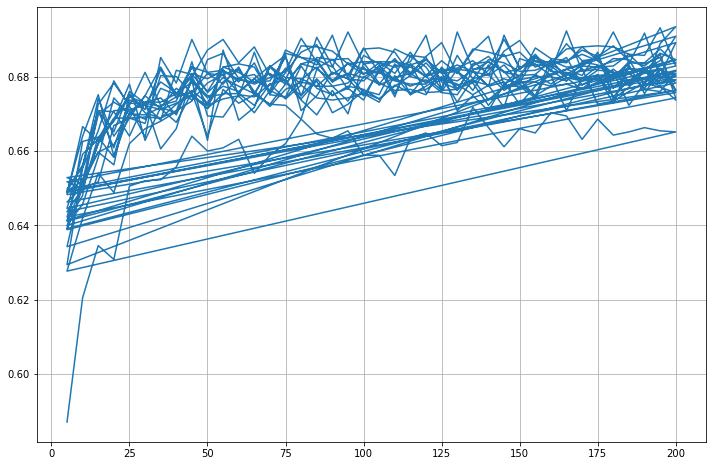

In [42]:
temp = result.loc[:, ['param_n_estimators', 'mean_test_score']]

plt.figure(figsize=(12, 8))
plt.plot('param_n_estimators', 'mean_test_score', data=temp)
plt.grid()
plt.show()
# 경향에서 어긋나는 지점이 아닌 경향을 확인하고 그 근방에서 찾는게 좋음 -> 100~200 사이면 충분(대체로 이럼) -> 그냥 defalut값으로 사용해도 되겠다 !
# 랜덤포레스트는 트리가 많아진다고 모델이 복잡해지지 않음(* 트리가 많으면 과적합을 방지함 * => 평균을 쓰기 때문에)

### (2) max_features 튜닝

In [43]:
x_train.shape

(3500, 20)

In [44]:
# 1~20개까지 조절가능
params = {'max_features' : range(1, 21)}
# 기본모델
rf = RandomForestClassifier()

In [46]:
# 그리드서치 모델
model_rf = GridSearchCV(rf, params, cv=5, verbose=3)
model_rf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END .................................max_features=1; total time=   0.5s
[CV 2/5] END .................................max_features=1; total time=   0.5s
[CV 3/5] END .................................max_features=1; total time=   0.5s
[CV 4/5] END .................................max_features=1; total time=   0.6s
[CV 5/5] END .................................max_features=1; total time=   0.5s
[CV 1/5] END .................................max_features=2; total time=   0.5s
[CV 2/5] END .................................max_features=2; total time=   0.5s
[CV 3/5] END .................................max_features=2; total time=   0.5s
[CV 4/5] END .................................max_features=2; total time=   0.5s
[CV 5/5] END .................................max_features=2; total time=   0.7s
[CV 1/5] END .................................max_features=3; total time=   0.8s
[CV 2/5] END .................................m

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21)}, verbose=3)

In [49]:
print(model_rf.best_params_)
print(model_rf.best_score_)

{'max_features': 5}
0.6877142857142858


In [50]:
# 튜닝 결과를  df로 저장
result = pd.DataFrame(model_rf.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.584351,0.046218,0.041438,0.003429,1,{'max_features': 1},0.647143,0.674286,0.661429,0.667143,0.682857,0.666571,0.012075,20
1,0.600260,0.063229,0.041279,0.007621,2,{'max_features': 2},0.665714,0.685714,0.682857,0.690000,0.702857,0.685429,0.012000,4
2,0.750378,0.105458,0.040866,0.007190,3,{'max_features': 3},0.671429,0.711429,0.677143,0.682857,0.691429,0.686857,0.013950,2
3,0.782469,0.039766,0.046731,0.015350,4,{'max_features': 4},0.651429,0.702857,0.680000,0.664286,0.682857,0.676286,0.017464,15
4,0.886183,0.065799,0.044852,0.010035,5,{'max_features': 5},0.658571,0.718571,0.667143,0.692857,0.701429,0.687714,0.022087,1


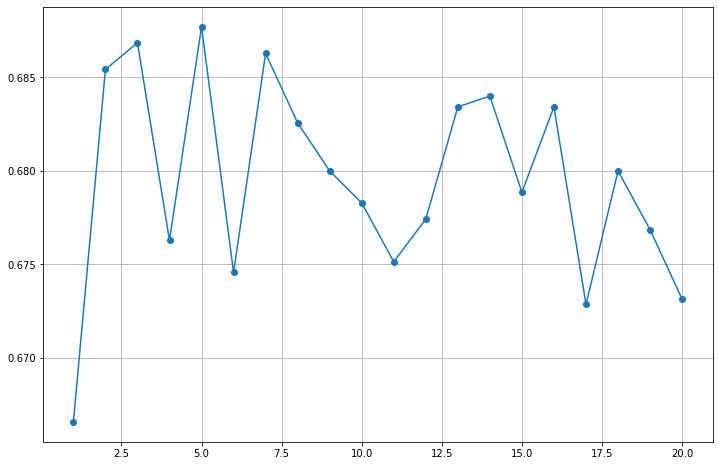

In [54]:
temp = result.loc[:, ['param_max_features', 'mean_test_score']]

plt.figure(figsize=(12, 8))
plt.plot('param_max_features', 'mean_test_score', '-o', data=temp)
plt.grid()
plt.show()
# 경향에서 어긋나는 지점이 아닌 경향을 확인하고 그 근방에서 찾는게 좋음 -> sqrt(n_features)정도가 적당, 경향성 파악하자

* 변수 중요도

In [ ]:
result = plot_feature_importance(model_rf.feature_importances_, x_train.columns)

### (3) n_estimators와 max_features를 한꺼번에 튜닝

In [57]:
params = {'n_estimators' : [20, 50, 100], 'max_features' : range(1, 21)}
rf = RandomForestClassifier()

In [58]:
model_rf_1 = GridSearchCV(rf, params, cv=5, verbose=3)
model_rf_1.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ................max_features=1, n_estimators=20; total time=   0.1s
[CV 2/5] END ................max_features=1, n_estimators=20; total time=   0.1s
[CV 3/5] END ................max_features=1, n_estimators=20; total time=   0.1s
[CV 4/5] END ................max_features=1, n_estimators=20; total time=   0.1s
[CV 5/5] END ................max_features=1, n_estimators=20; total time=   0.1s
[CV 1/5] END ................max_features=1, n_estimators=50; total time=   0.3s
[CV 2/5] END ................max_features=1, n_estimators=50; total time=   0.3s
[CV 3/5] END ................max_features=1, n_estimators=50; total time=   0.2s
[CV 4/5] END ................max_features=1, n_estimators=50; total time=   0.3s
[CV 5/5] END ................max_features=1, n_estimators=50; total time=   0.4s
[CV 1/5] END ...............max_features=1, n_estimators=100; total time=   0.6s
[CV 2/5] END ...............max_features=1, n_e

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': range(1, 21),
                         'n_estimators': [20, 50, 100]},
             verbose=3)

<function matplotlib.pyplot.show(close=None, block=None)>

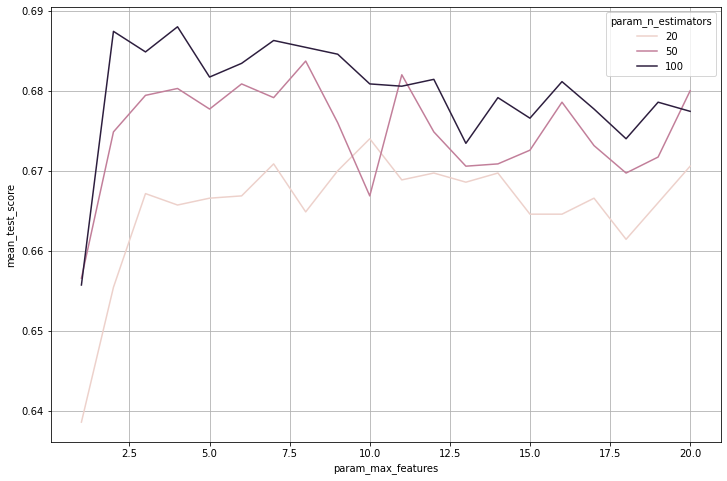

In [59]:
result = pd.DataFrame(model_rf_1.cv_results_)

temp = result.loc[:, ['param_n_estimators','param_max_features', 'mean_test_score']]

plt.figure(figsize=(12, 8))
sns.lineplot('param_max_features', 'mean_test_score', data=temp, hue='param_n_estimators')
plt.grid()
plt.show